In [19]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/PFE/PFE

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/PFE/PFE'
/content/gdrive/My Drive/PFE/PFE


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset
from prep_dataset import *
from models.GCN_model import *
from models.GIN_model import *
from train import *

In [0]:
# Setting up the default data type
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device('cuda') if use_cuda else torch.device('cpu')
dtype = torch.float32
torch.set_default_tensor_type(FloatTensor)

In [0]:
ds_name = "PTC_MR"
batch_size = 128
n_folds = 10
folded_train_data, folded_test_data, folded_valid_data, info = get_folded_data(ds_name, batch_size, n_folds)

In [0]:
learning_rate = 0.0005
num_epochs = 500
n_features = info[0]
hidden_dim = 20
n_classes = info[1]
dropout = 0.01
n_gnn_layers = 5
n_mlp_layers = 2

Percentage of class 0: 55.81%
Percentage of class 1: 44.19%


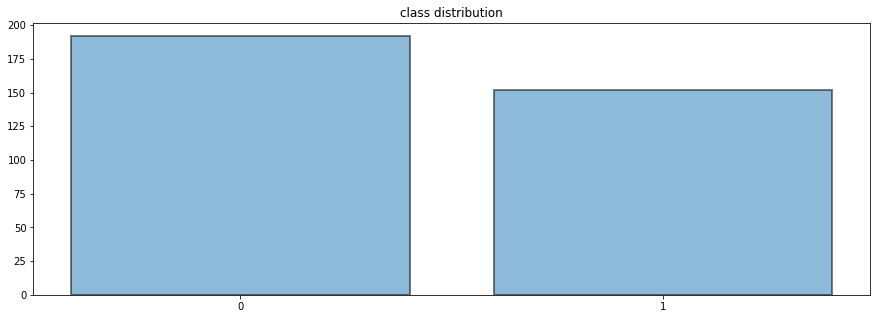

In [24]:
counts = np.zeros(n_classes)
h_labels = []
for _, _, labels in folded_train_data[0]:
    h_labels.append(labels.cpu().tolist())
    unique, count = np.unique(labels.cpu(), return_counts=True)
    counts += count
for _, _, labels in folded_valid_data[0]:
    h_labels.append(labels.cpu().tolist())
    unique, count = np.unique(labels.cpu(), return_counts=True)
    counts += count
for _, _, labels in folded_test_data[0]:
    h_labels.append(labels.cpu().tolist())
    unique, count = np.unique(labels.cpu(), return_counts=True)
    counts += count

###
for cl in unique:
    print("Percentage of class {}: {:.2f}%".format(cl, 100*counts[cl]/sum(counts)))
####
fig = plt.figure(figsize=(15,5))
ax = plt.axes()
ax.bar(unique, counts, align='center', alpha=0.5, edgecolor='black', linewidth=2)
ax.set_title("class distribution")
ax.set_xticks(unique)
plt.show()

Streaming output truncated to the last 5000 lines.
Fold no. 1, epoch [2/500], Loss: 18.6826, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [3/500], Loss: 15.6431, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [4/500], Loss: 13.5064, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [5/500], Loss: 10.3178, train_acc: 46.0, valid_acc: 31.0
Fold no. 1, epoch [6/500], Loss: 10.1125, train_acc: 46.0, valid_acc: 31.0
Fold no. 1, epoch [7/500], Loss: 7.5807, train_acc: 48.0, valid_acc: 31.0
Fold no. 1, epoch [8/500], Loss: 5.7878, train_acc: 48.0, valid_acc: 31.0
Fold no. 1, epoch [9/500], Loss: 5.6292, train_acc: 49.0, valid_acc: 31.0
Fold no. 1, epoch [10/500], Loss: 3.4825, train_acc: 54.0, valid_acc: 31.0
Fold no. 1, epoch [11/500], Loss: 2.8418, train_acc: 54.0, valid_acc: 31.0
Fold no. 1, epoch [12/500], Loss: 2.6545, train_acc: 58.0, valid_acc: 31.0
Fold no. 1, epoch [13/500], Loss: 2.1310, train_acc: 59.0, valid_acc: 31.0
Fold no. 1, epoch [14/500], Loss: 2.3438, train_acc:

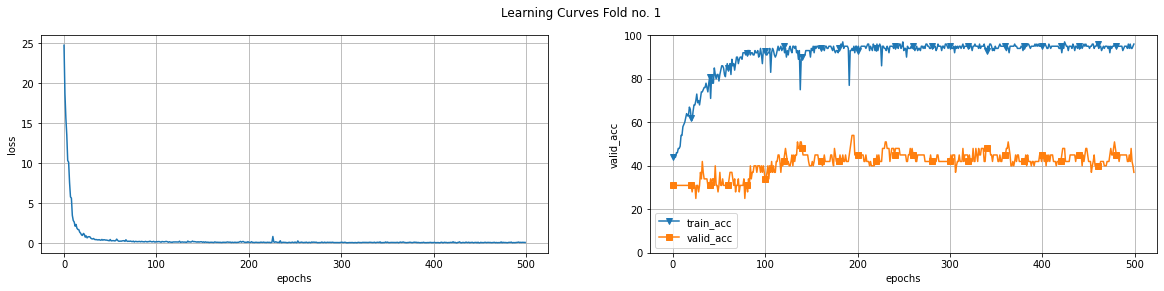

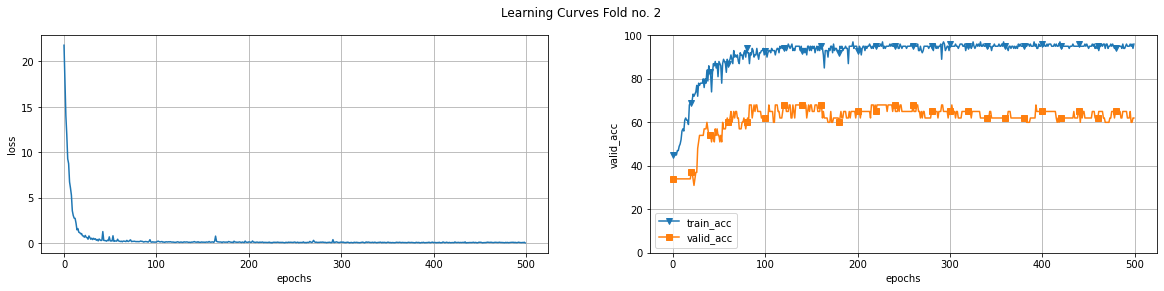

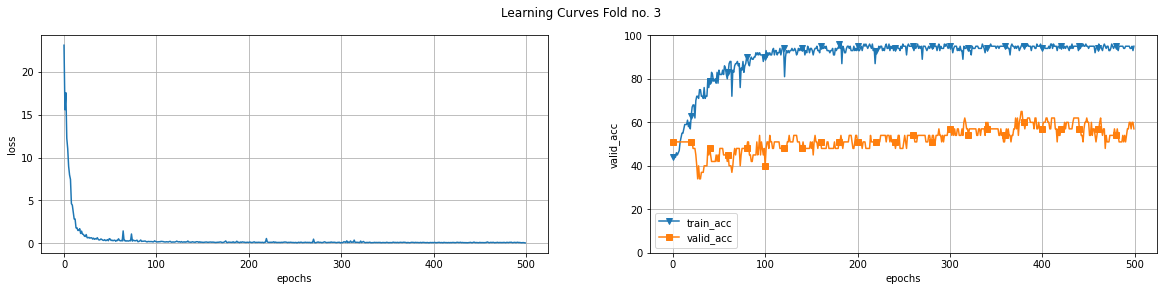

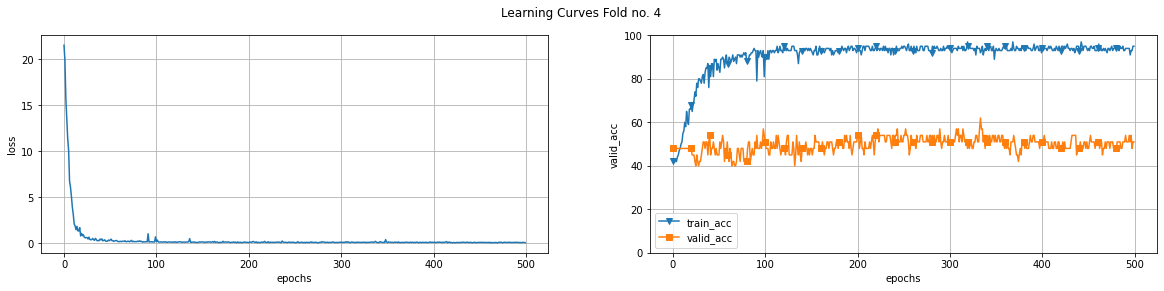

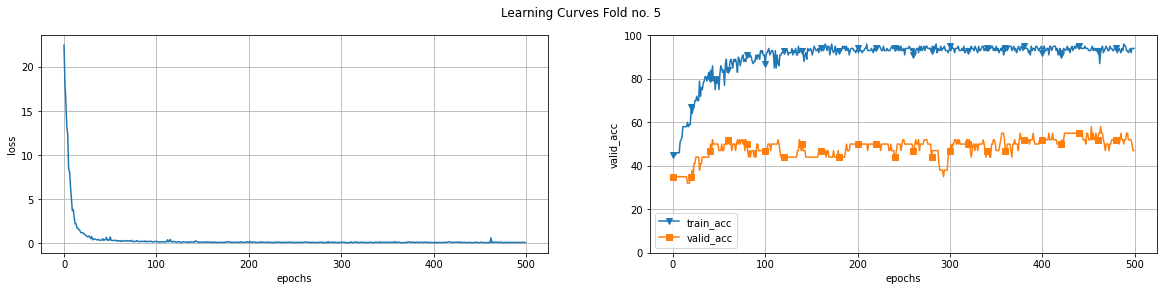

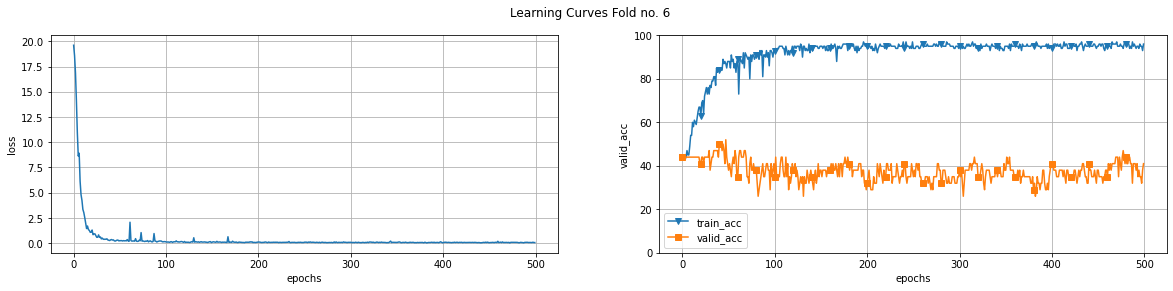

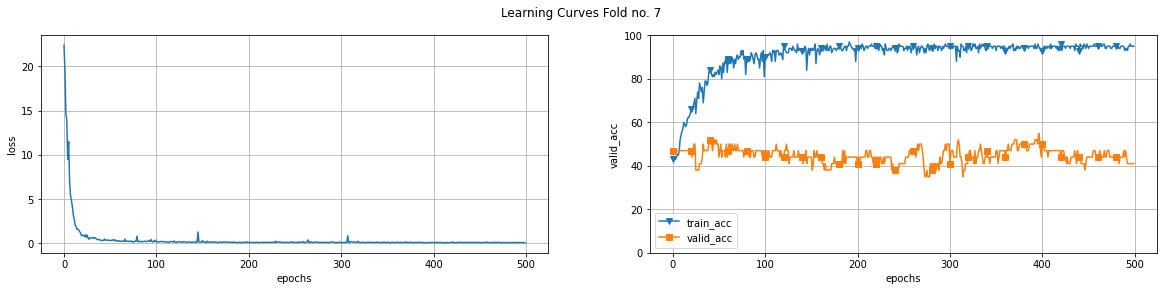

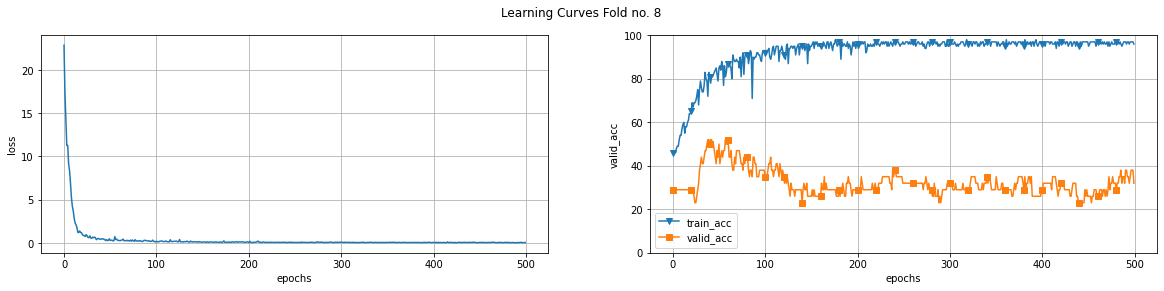

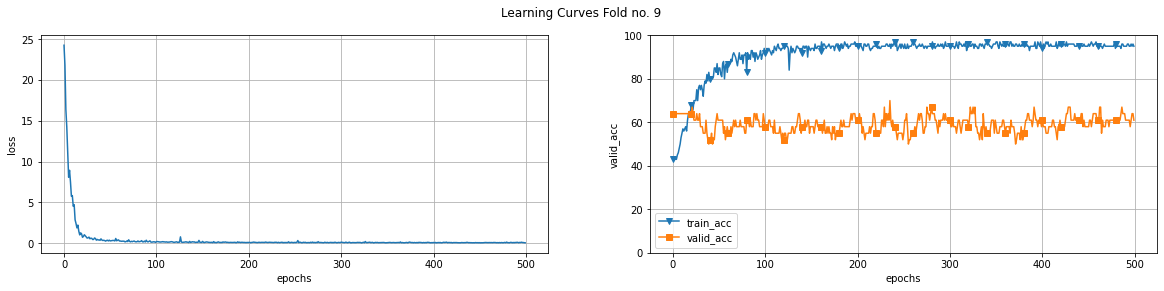

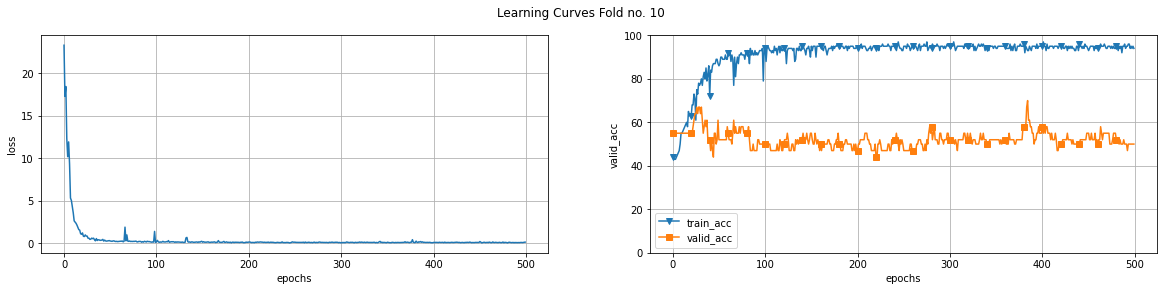

Average training accuracy across the 10 folds: 95.2
Average validation accuracy across the 10 folds: 47.9


In [25]:
model = GIN(n_gnn_layers, n_mlp_layers, input_dim=n_features, hidden_dim=hidden_dim, 
            output_dim=n_classes, learn_eps=False, dropout=dropout, attention=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_GNN(model, folded_train_data, folded_test_data, optimizer, criterion, num_epochs=num_epochs, device=device)

Streaming output truncated to the last 5000 lines.
Fold no. 1, epoch [2/500], Loss: 2.5258, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [3/500], Loss: 2.2798, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [4/500], Loss: 2.1067, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [5/500], Loss: 2.2011, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [6/500], Loss: 1.9343, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [7/500], Loss: 1.8978, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [8/500], Loss: 1.9553, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [9/500], Loss: 1.8176, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [10/500], Loss: 2.0430, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [11/500], Loss: 1.6399, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [12/500], Loss: 1.5497, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [13/500], Loss: 1.5578, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [14/500], Loss: 1.4576, train_acc: 44.0

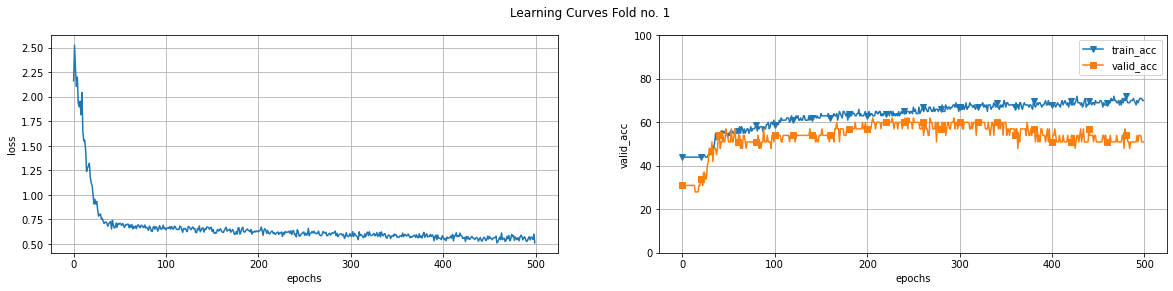

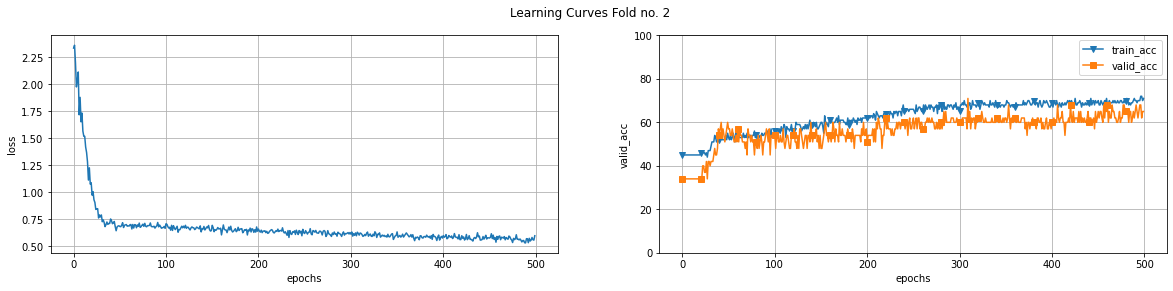

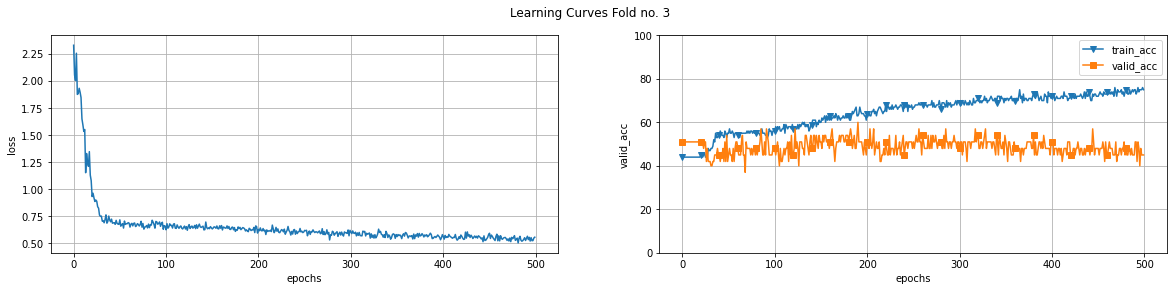

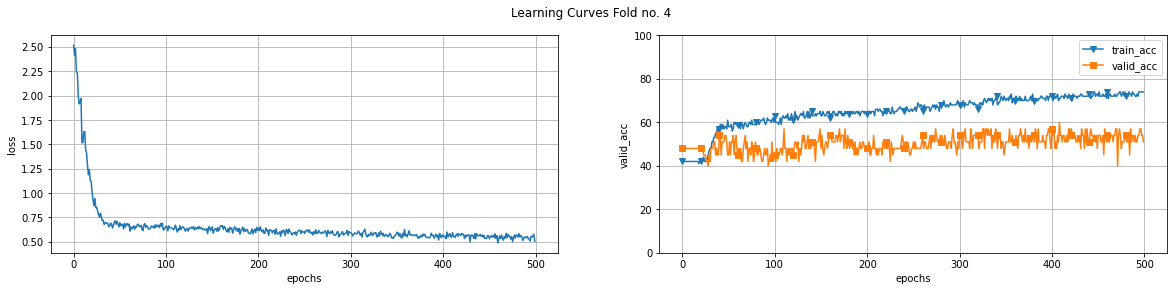

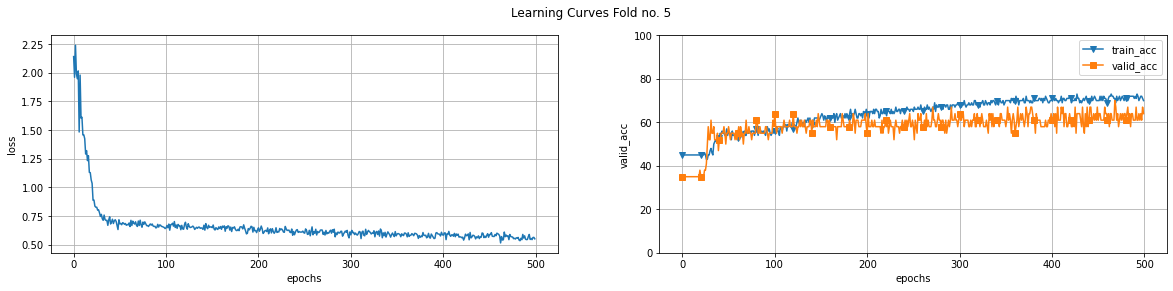

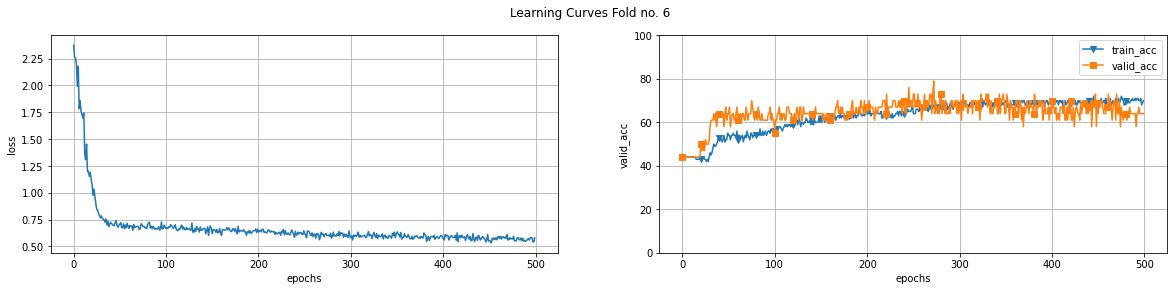

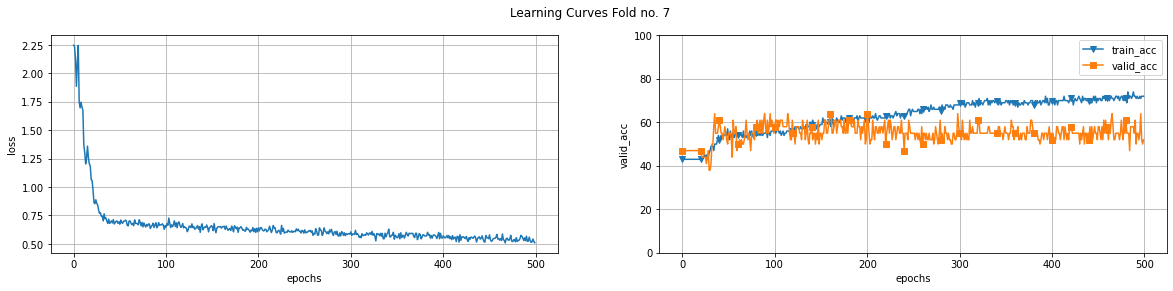

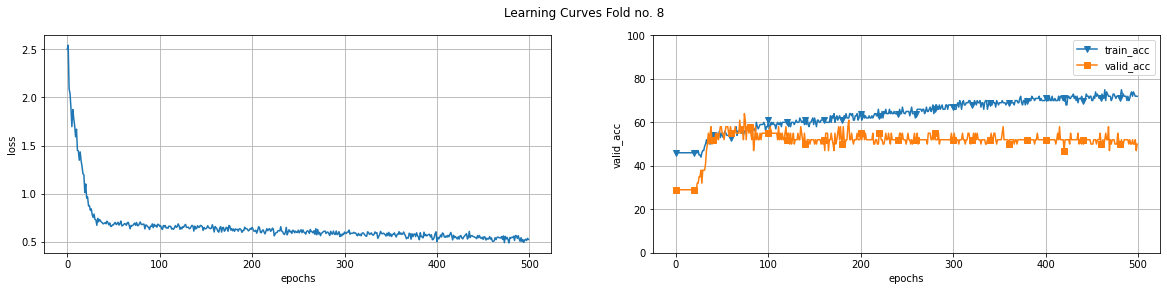

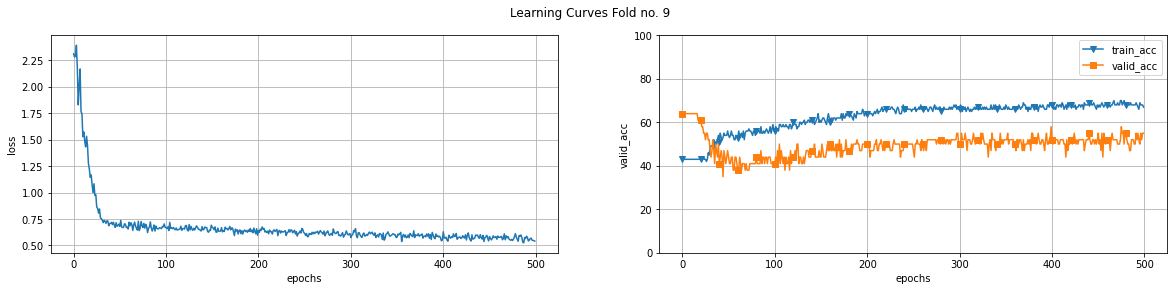

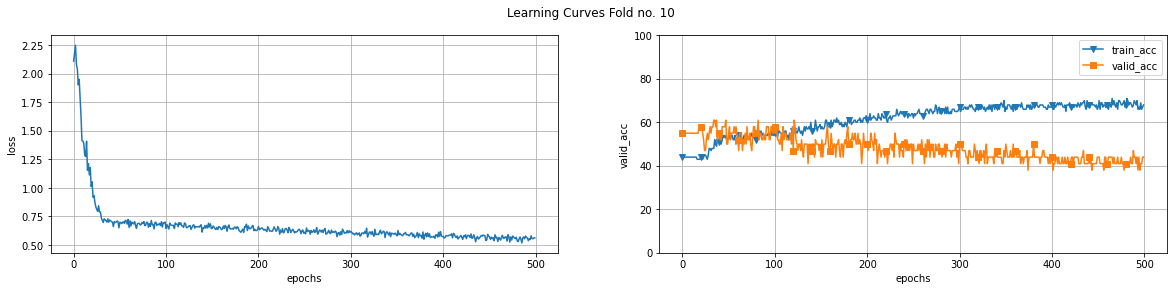

Average training accuracy across the 10 folds: 70.9
Average validation accuracy across the 10 folds: 54.1


In [27]:
model = TwoLayerGCN(input_dim=n_features, hidden_dim=hidden_dim, 
                    n_classes=n_classes, dropout=dropout, attention=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_GNN(model, folded_train_data, folded_test_data, optimizer, criterion, num_epochs=num_epochs, device=device)

models/layers.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = F.softmax(scores).flatten()


Streaming output truncated to the last 5000 lines.
Fold no. 1, epoch [2/500], Loss: 0.8513, train_acc: 57.0, valid_acc: 68.0
Fold no. 1, epoch [3/500], Loss: 0.7932, train_acc: 56.0, valid_acc: 68.0
Fold no. 1, epoch [4/500], Loss: 0.7764, train_acc: 59.0, valid_acc: 68.0
Fold no. 1, epoch [5/500], Loss: 0.7267, train_acc: 64.0, valid_acc: 68.0
Fold no. 1, epoch [6/500], Loss: 0.7209, train_acc: 61.0, valid_acc: 68.0
Fold no. 1, epoch [7/500], Loss: 0.7383, train_acc: 56.0, valid_acc: 68.0
Fold no. 1, epoch [8/500], Loss: 0.6646, train_acc: 61.0, valid_acc: 68.0
Fold no. 1, epoch [9/500], Loss: 0.7579, train_acc: 58.0, valid_acc: 68.0
Fold no. 1, epoch [10/500], Loss: 0.7151, train_acc: 59.0, valid_acc: 68.0
Fold no. 1, epoch [11/500], Loss: 0.6912, train_acc: 63.0, valid_acc: 68.0
Fold no. 1, epoch [12/500], Loss: 0.7065, train_acc: 57.0, valid_acc: 68.0
Fold no. 1, epoch [13/500], Loss: 0.6912, train_acc: 64.0, valid_acc: 68.0
Fold no. 1, epoch [14/500], Loss: 0.6845, train_acc: 55.0

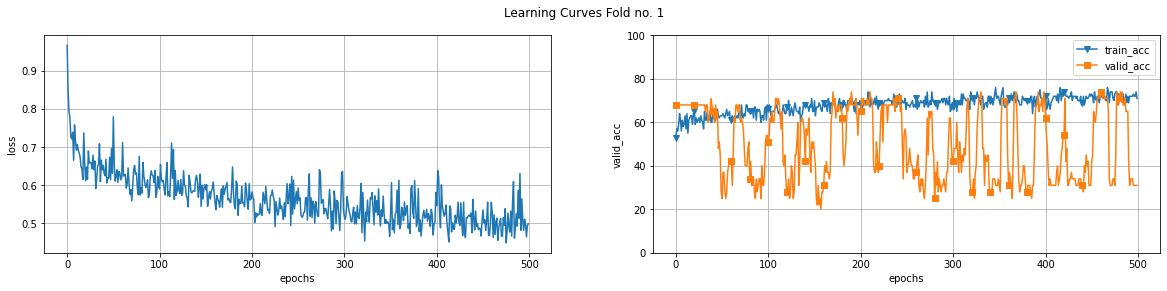

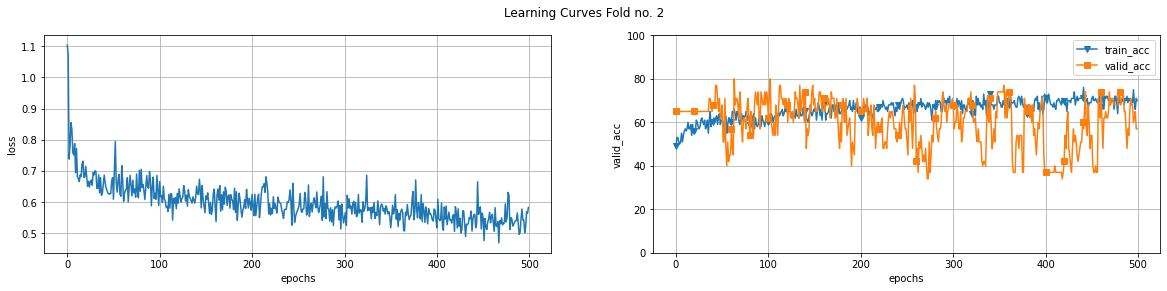

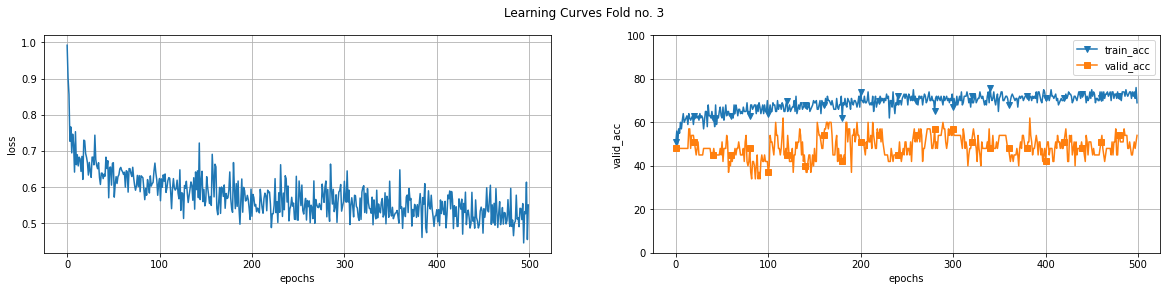

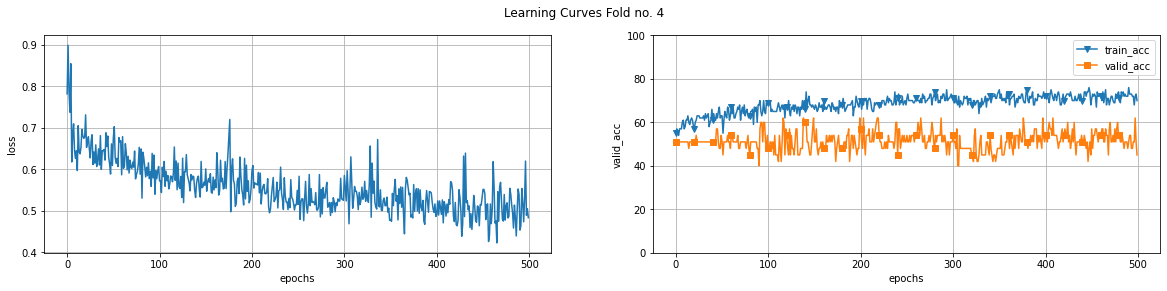

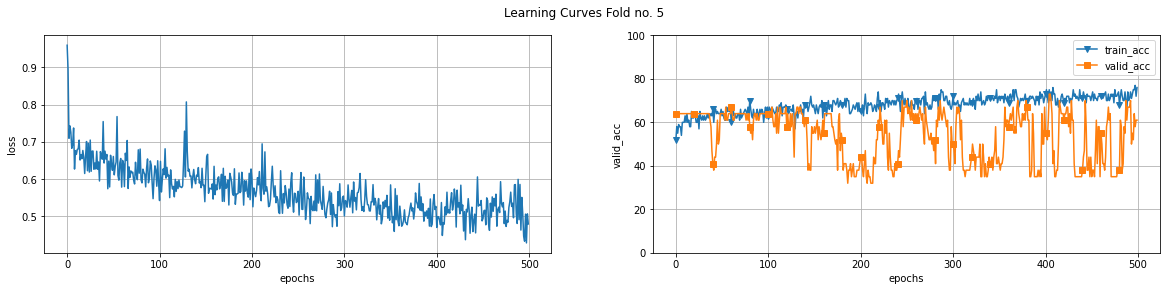

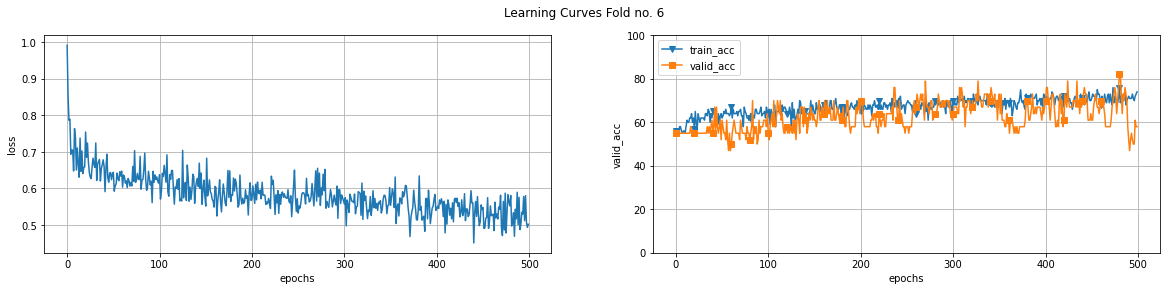

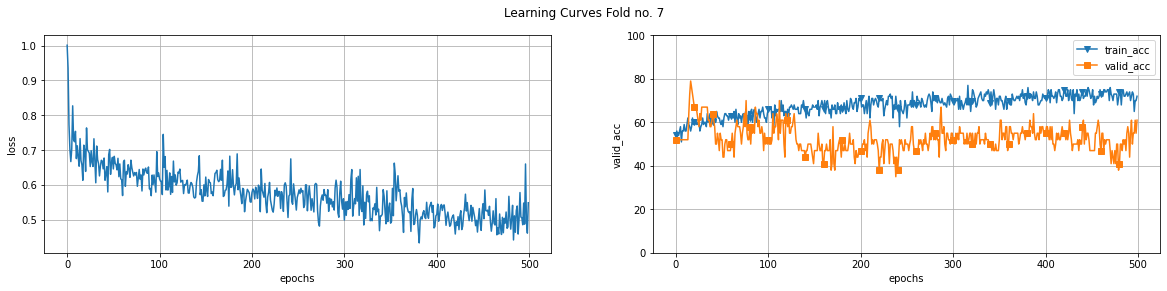

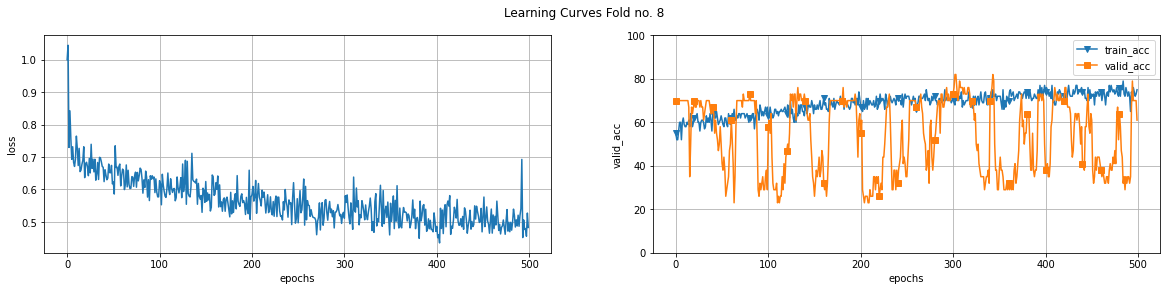

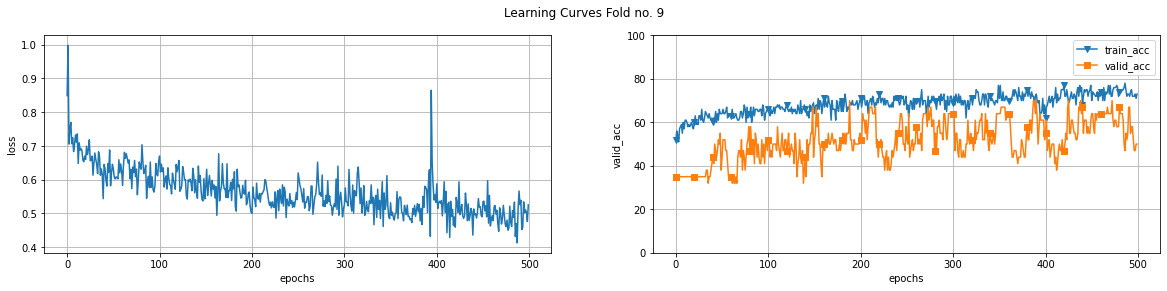

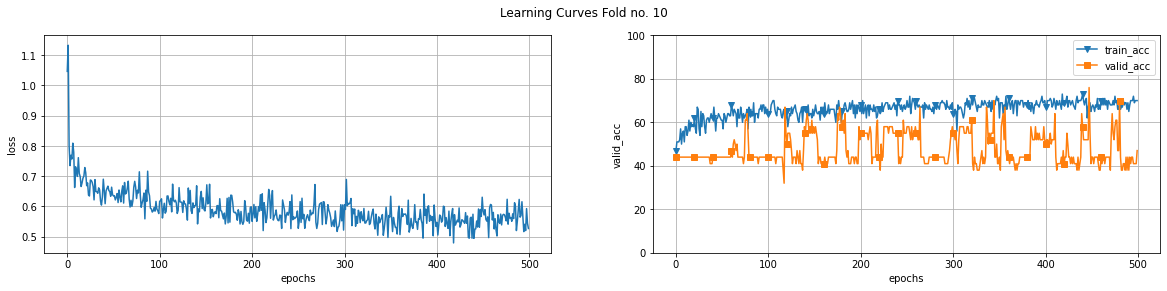

Average training accuracy across the 10 folds: 72.0
Average validation accuracy across the 10 folds: 52.5


In [28]:
model = GIN(n_gnn_layers, n_mlp_layers, input_dim=n_features, hidden_dim=hidden_dim, 
            output_dim=n_classes, learn_eps=False, dropout=dropout, attention=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_GNN(model, folded_train_data, folded_test_data, optimizer, criterion, num_epochs=num_epochs, device=device)

models/layers.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = F.softmax(scores).flatten()


Streaming output truncated to the last 5000 lines.
Fold no. 1, epoch [2/500], Loss: 1.8954, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [3/500], Loss: 1.8858, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [4/500], Loss: 1.7329, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [5/500], Loss: 1.8026, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [6/500], Loss: 1.6951, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [7/500], Loss: 1.7123, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [8/500], Loss: 1.4252, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [9/500], Loss: 1.4548, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [10/500], Loss: 1.5111, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [11/500], Loss: 1.4925, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [12/500], Loss: 1.1903, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [13/500], Loss: 1.2353, train_acc: 44.0, valid_acc: 31.0
Fold no. 1, epoch [14/500], Loss: 0.9018, train_acc: 44.0

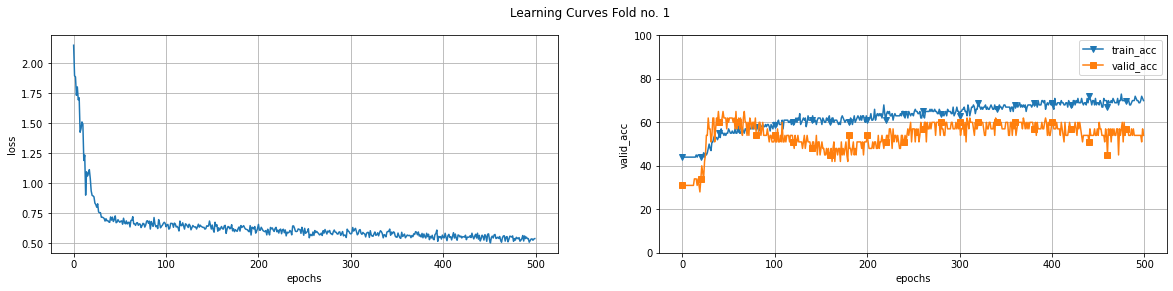

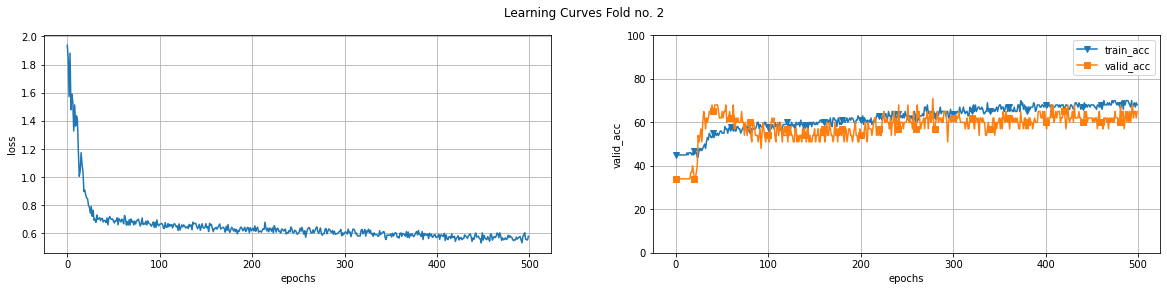

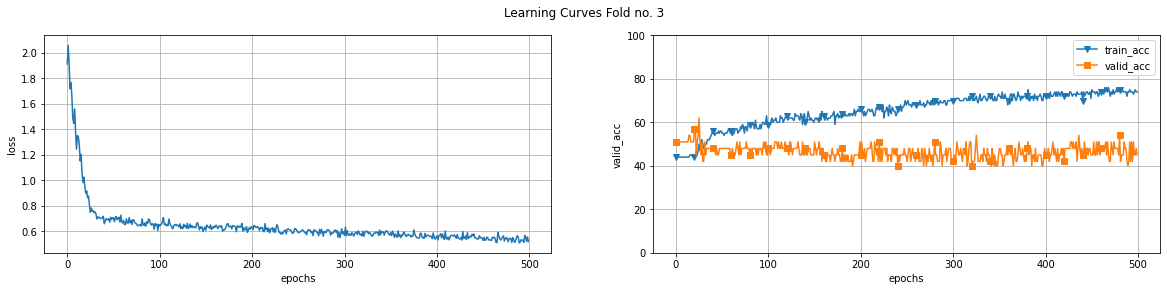

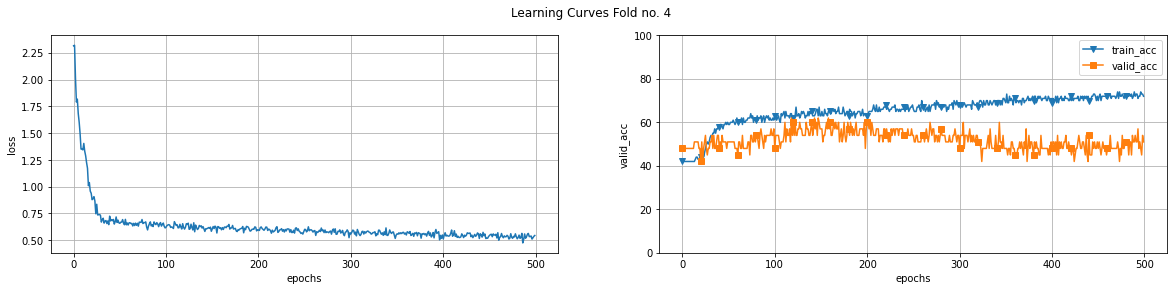

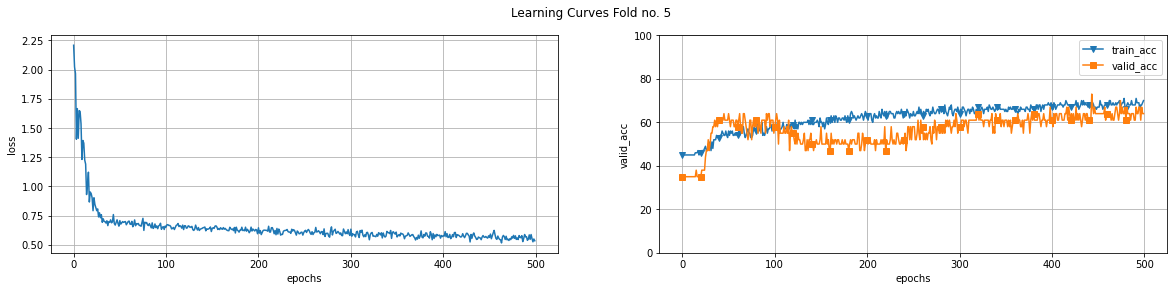

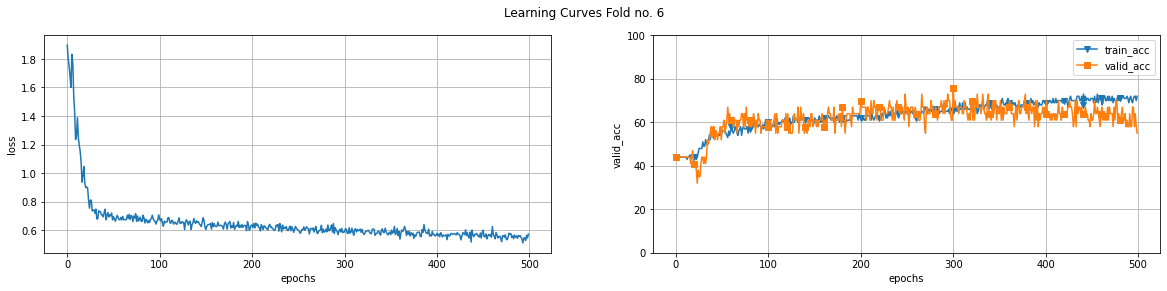

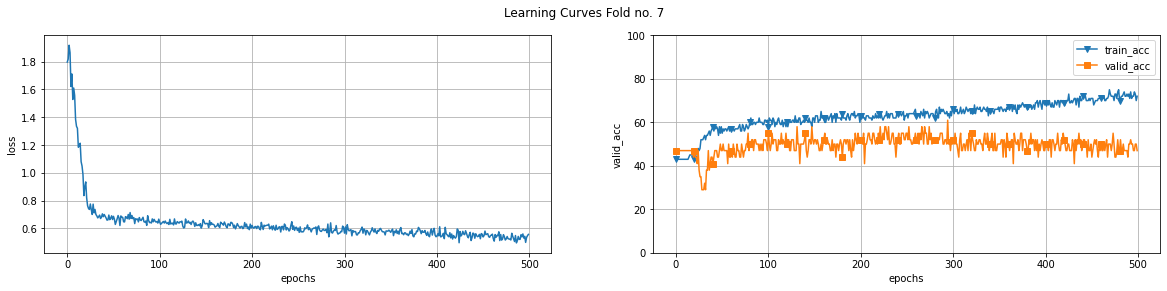

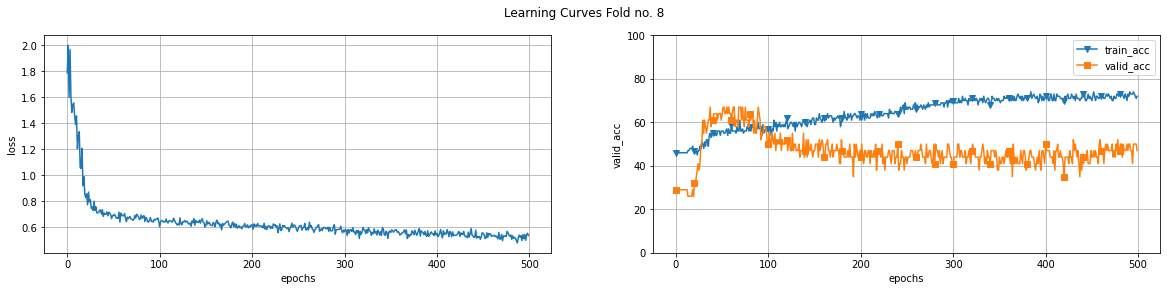

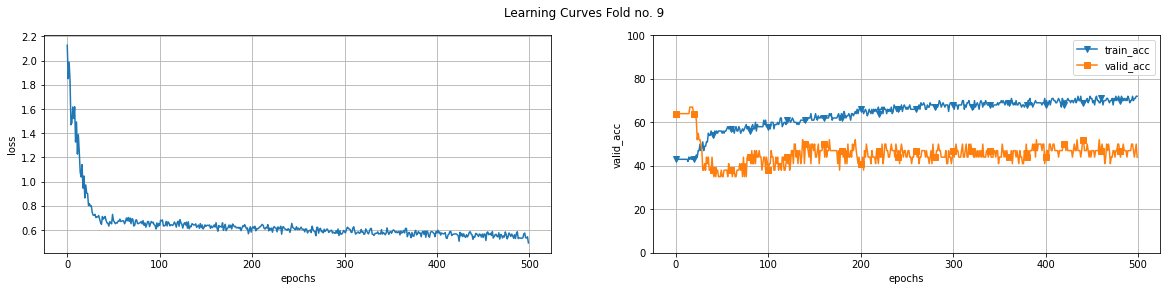

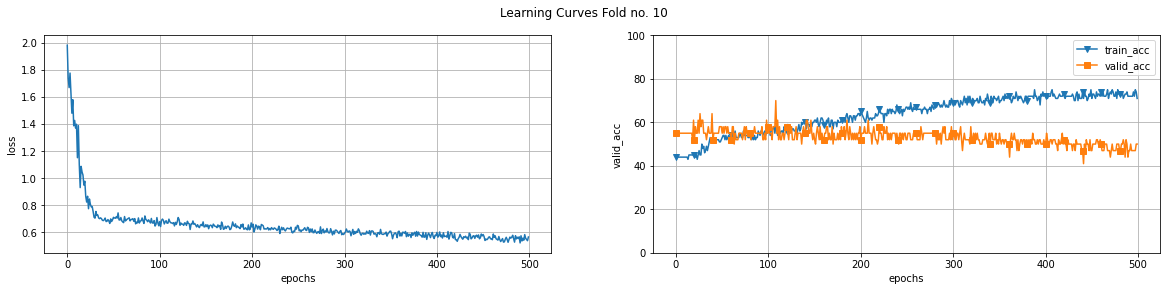

Average training accuracy across the 10 folds: 71.3
Average validation accuracy across the 10 folds: 52.2


In [29]:
model = TwoLayerGCN(input_dim=n_features, hidden_dim=hidden_dim, 
                    n_classes=n_classes, dropout=dropout, attention=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_GNN(model, folded_train_data, folded_test_data, optimizer, criterion, num_epochs=num_epochs, device=device)